# Assesing quality and spatio-temporal coverage of interferograms

**Author**: Emre Havazli, David Bekaert - Jet Propulsion Laboratory

This notebook provides an overview of the functionality included in the **`ariaPlot.py`** program. Specifically, we give examples on how the **`ariaPlot.py`** program can be used to generate both qualitative and coverage plots  of ARIA Geocoded UNWrapped interferogram (**GUNW**) products over a user defined area of interest.

In this notebook, we will demonstrate how to extract:
- Qualitative plots
  - Perpendicular baseline versus time plot
  - Coherence versus time plot
- Spatial coverage plots
  - interferogram latitude extent
    


<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. All other sections (Qualitative and Spatial coverage plots) do not need to be run in order
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
    
- GDAL uses "HDF5" driver instead of "netCDF/Network Common Data Format" on GUNW products. Verify GDAL version >= 3.
- ARIA-tools needs to be installed to run this notebook
</div>

## Prep A. Initial setup of the notebook

Below we define a plotting function that will be used for plotting the average coherence on a map.

In [1]:
import os
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter, StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable



def plot_layer(path_layer, lay_type=None, cmap=None, **kwargs):
    """ 
        path_layers is a string to the GDAL compatible dataset to be plotted
    """
    
    if not lay_type: 
        lay_type = os.path.dirname(path_layer)
    title = [os.path.basename(lay_type)]
    
    ## get the lon lat bounds
    ds       = gdal.Open(path_layer, gdal.GA_ReadOnly)
    trans    = ds.GetGeoTransform()
    extent   = [trans[0], trans[0] + ds.RasterXSize * trans[1], trans[3] + ds.RasterYSize*trans[5], trans[3]]
    
    ## loading the data
    n_bands  = ds.RasterCount
    lst_arrs = []
    
    for band in range(n_bands):
        raster = ds.GetRasterBand(band+1)
        arr    = raster.ReadAsArray()
        try:
            NoData = raster.GetNoDataValue()
            arr = np.ma.masked_where((arr>1e20) |(arr==NoData),arr )
        except:
            print('Could not find a no-data value...')
            arr = np.ma.masked_where(arr>1e20,arr)
        
        lst_arrs.append(arr)

    ds = None
    if n_bands < 4:
        nrows = 1; ncols = n_bands
    else:
        raise Exception('Number of bands currently unsupported')
        
    
    ## initializing a figure
    fig, axes = plt.subplots(figsize=(12,9), ncols=ncols, nrows=nrows, sharex='col', sharey='row')
    axes = axes if isinstance(axes, np.ndarray) else np.array(axes)
    axe  = axes.ravel() 
    cmap = plt.cm.Greys_r
    cmap.set_under('black')
    
    ## definging the plotting options for differnt layer types
    # Amplitude:
    if lay_type.endswith('amplitude'): 
        # will fix the maximum amplitude bound
        vmin=None
        vmax = 2000 
    # Coherence:
    elif lay_type.endswith('coherence'): 
        # has fixed range between 0-1
        vmin=0
        vmax = 1
    # Incidence angle:
    elif lay_type.endswith('incidenceAngle'): 
        vmin=None
        vmax=None
    # water
    elif lay_type.startswith('water'):
        # no bounds needed will be a 0/1 mask
        vmin=None
        vmax=None
    # deformation or unwrapped phase
    elif lay_type.startswith('defo'): 
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
    elif lay_type.startswith('terr') or lay_type.startswith('topo'): 
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.terrain
    elif lay_type == 'ENU':
        vmin=None
        vmax=None
        title = ['East', 'North', 'Up']
        fig.subplots_adjust(wspace=0.5)

    else:
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
        
    # plotting the data    
    for i, ax in enumerate(axe):
        im   = ax.imshow(lst_arrs[i], cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='5%', pad=0.25)
        if lay_type == 'ENU':
            fig.colorbar(im, cax=cax, format=FuncFormatter(lambda x, y: '{:.3f}'.format(x)))
        else:
            fig.colorbar(im, cax=cax)

        ax.set_title(title[i], fontsize=15)
        ax.grid(False)

    axe[0].set_ylabel('latitude', labelpad=15, fontsize=15)
    axe[int(np.floor(n_bands/2))].set_xlabel('longitude', labelpad=15, fontsize=15)

## Prep B: Download the data

### Tutorial dataset 

For this tutorial we will use San-Francisco as study area. ARIA provides unwrapped interferograms as GUNW products. We will use a Sentinel-1 interferograms generated on track 42, spanning the start of Sentinel-1 till 20160101. As the spatial extend of a product is roughly the size of a Sentinel-1 SLC frame (250km x 250km), it is likely that an interferogram over your study area is composed of multiple adjacent GUNW frames or products. 

### ARIA GUNW products

The GUNW product is an InSAR surface displacement products as derived Sentinel-1 and packaged as netCDF4 files. The products contain both data and meta-data layers such as interferogram amplitude, filtered unwrapped phase, filtered coherence, connected components, perpendicular and parallel baselines, incidence, azimuth and look angles. A detailed overview of the ARIA GUNW product with respect to processing, formatting, sampling, and data layers can be found on the [ARIA website](https://aria.jpl.nasa.gov/node/97).

### Download options

GUNW products are hosted at the ASF DAAC and can be downloaded from the [ARIA-products page](https://aria-products.jpl.nasa.gov) and under beta products from the [ASF DAAC vertex page](https://vertex.daac.asf.alaska.edu). If you know the GUNW filename of the product, you can also build a download link by appending the GUNW filename to **https://<i></i>grfn.asf.alaska.edu<i></i>/door/download/** . 

Alternatively, you can use the **`ariaDownload.py`** program provided within the ARIA-tools package to download data using a command-line interface. This program wraps around the ASF DAAC API and allows for search sub setting of GUNW products based on track number, geometry (ascending or descending), as well as, spatial and temporal bounding boxes criteria. For a full description of **`ariaDownload.py`** program, see the [ariaDownload Tutorial](https://github.com/aria-tools/ARIA-tools-docs/blob/master/JupyterDocs/ariaDownload/ariaDownload_tutorial.ipynb).

<div class="alert alert-warning">
<b>Potential download failure:</b> 
GUNW products are hosted at the NASA ASF DAAC. Downloading them requires a NASA Earthdata URS user login and requires users to add “ARIA Product Search” to their URS approved applications
</div>

Below we will use the **`ariaDownload.py`** to download the all the GUNW products on track 42 (**`-t`** option) over San Francisco area (**`--bbox`** SNWE option) for the interferograms between 2014 (**`--s`** options) and *20160101* (**`--e`** option) into a *products* folder (**`-w`** option).


<div class="alert alert-danger">
<b>Download</b>: 
    
- <b>Can take up to 20 min</b>, so this is a good moment to take a cofee-break!
- The ***jupuyter notebook* does not allow for interactive entering of your user-name and password, use the *jupyter terminal* instead** with the same command for interactive use.
</div>

In [3]:
!ariaDownload.py -t 42 -e 20160101  --bbox "37 38 -122.5 -120"

https://api.daac.asf.alaska.edu/services/search/param?asfplatform=Sentinel-1%20Interferogram%20(BETA)&output=JSON&relativeOrbit=42&bbox=-122.5,37,-120,38
 > attempting to download https://urs.earthdata.nasa.gov/profile
 > Re-using previous cookie jar.
 > Download file S1-GUNW-D-R-042-tops-20151214_20151003-140745-38457N_36481N-PP-5d6d-v2_0_2.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20151214_20151003-140745-38457N_36481N-PP-5d6d-v2_0_2.nc. 
 > Download file S1-GUNW-D-R-042-tops-20151214_20151027-140745-38457N_36481N-PP-eeff-v2_0_0.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20151214_20151027-140745-38457N_36481N-PP-eeff-v2_0_0.nc. 
 > Download file S1-GUNW-D-R-042-tops-20151214_20151120-140745-38457N_36481N-PP-a9c7-v2_0_0.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20151214_20151120-140745-38457N_36481N-PP-a9c7-v2_0_0.nc.

 > Download file S1-GUNW-D-R-042-tops-20150816_20150629-140750-38125N_36148N-PP-4a99-v2_0_0.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150816_20150629-140750-38125N_36148N-PP-4a99-v2_0_0.nc. 
 > Download file S1-GUNW-D-R-042-tops-20150816_20150605-140725-39616N_37641N-PP-240a-v2_0_2.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150816_20150605-140725-39616N_37641N-PP-240a-v2_0_2.nc. 
 > Download file S1-GUNW-D-R-042-tops-20150816_20150723-140725-39616N_37641N-PP-53d0-v2_0_0.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150816_20150723-140725-39616N_37641N-PP-53d0-v2_0_0.nc. 
 > Download file S1-GUNW-D-R-042-tops-20150816_20150629-140725-39616N_37641N-PP-b4b2-v2_0_0.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150816_20150629-140725-39616N_37641N-PP-b4b2-v2_0_0.nc. 


## Overview of the ariaPlot.py program

The **`ariaPlot.py`** program allows for easy generation of qualitative and spatio-temporal coverage plots of interferograms over a user-defined area of interest. Running **`ariaPlot.py`** with the **`-h`** option, will show the parameters options. 

Let us explore these options are:

In [4]:
!ariaPlot.py -h

usage: ariaPlot.py [-h] -f IMGFILE [-w WORKDIR] [-b BBOX] [-m MASK]
                   [-at AMP_THRESH] [-of OUTPUTFORMAT] [-croptounion]
                   [-plottracks] [-plotbperp] [-plotbperpcoh] [-plotcoh]
                   [-makeavgoh] [-plotall] [-verbose]

Function to generate various quality control and baseline figures of the
spatial-temporal network of products.

optional arguments:
  -h, --help            show this help message and exit
  -f IMGFILE, --file IMGFILE
                        ARIA file
  -w WORKDIR, --workdir WORKDIR
                        Specify directory to deposit all outputs. Default is
                        local directory where script is launched.
  -b BBOX, --bbox BBOX  Provide either valid shapefile or Lat/Lon Bounding
                        SNWE. -- Example : '19 20 -99.5 -98.5'
  -m MASK, --mask MASK  Path to mask file or 'Download'. File needs to be GDAL
                        compatabile, contain spatial reference information,
               

### 1. Product files to be used (-f option)

At minimum, users need to specify the GUNW files where they want to extract information from. This is controlled using the **`-f`** option. Multiple products can be specified by providing them as a comma separated string (e.g., **`-f`**` 'S1-GUNW-A-R-124-tops-20180502_20180408-043106-21658N_19755N-PP-0dd0-v2_0_1.nc,S1-GUNW-A-R-124-tops-20180502_20180408-043040-20161N_18088N-PP-6704-v2_0_1.nc'`), or using a wildcard (e.g., **`-f`**` 'S1*.nc'`).

### 2. Cropping and spatial sub setting (-b and -croptounion options)

The **`ariaPlot.py`** program will automatically handle cropping and stitching of GUNW products when needed. By default, the program will crop all interferograms to bounds determined by the common intersection (of all interferograms) and the user-defined bounding box option. All layers are cropped and/or stitched using GDAL (see the methods section for details on the implemented approach for each layer). Below we discuss which options are available for specifying an area-of-interest.

#### Interferogram intersection versus union (-croptounion option)

GUNW products are grouped in clusters that belong to the same interferometric pair. By default, the spatial **intersection** of the interferometic pairs is used to define the region of interest. This can be overwritten to be the union of all interferograms (regardless of alignment) by passing the **`--croptounion`** argument. A schematic example is shown in **Fig 1** for both scenario's.

<div class="alert alert-warning">
<b>Warning:</b> Users in general should avoid mixing products of adjacent satellite tracks (i.e., products made on the same contiguous pass are ok). Note that along the equator, the track number (ascending data on the ascending note) gets incremented while the data itself is still continuous.
</div>

<img src="support_docs/spatial_config_new.png" alt="spatial_configuration" width="700">
<blockquote> <center><b> Fig. 1 </b> Schematic of the spatiotemporal configuration for three interferograms. The left panel shows the intersection of the interferograms, which is the default behavior. The right panel shows the union of the interferograms, achieved by passing <b><code>--croptounion</code></b> . The blue dashed line demonstrates the behavior if the user had specified a bounding box (<b><code>-b</code></b>). Note that interferograms which do not cover the bounding box completely with the <b><code>--croptounion</code></b> or the <b><code>-b</code></b> option, will be patched with no-data values.</center></blockquote>

#### Bounding Box (-b option)

The user can specify a rectangular bounding box (South-North-West-East coordinates) as **`-b`**` 'S N W E'` or can provide a more complex area of interest using a shapefile or geoJSON as **`-b`**` path_to_file.shp`. A schematic example is shown in **Fig 2** for both scenario's.

<img src="./support_docs/crop.png" alt="cropping" width="700">
<blockquote><center><b> Fig. 2 </b> Schematic examples of the <b><code>-b</code></b> option available for cropping. The blue dashed line shows the user-specified area of interest. The left panel demonstrates the use when specifying SNWE coordinates, while the right panel shows when specifying a more complex polygon for the area of interest using a shapefile. </center></blockquote>

### 3. Workdirectory (-w option)

The output of the **`ariaPlot.py`** program is saved within the working directory (**`-w`**), which by default is the current directory. Within the work directory the outputs of **`ariaPlot.py`** (figures and average coherence raster) are stored within the *figures* directory.

### 4.  Output format (-o option)

The **`ariaPlot.py`** program leverages GDAL for file reading and writing of outputs. Although most of the outputs are figures, users can specify any GDAL compatible format (e.g., ENVI, ISCE, GTiff; see GDAL for more information on supported format) for saving the output from the **`--makeavgoh`** option.

## Qualitative Plots

Users can analyze the interferogram quality over their study area by examining the interferogram baseline and average coherence information. **`ariaPlot.py`** allows user to visualize this information directly from the GUNW products. Three main options are available that can assist users for a qualitative assessment. The **`--plotbperpcoh`** option generates a perpendicular baseline plot over time color-coded with average coherence. An alternative representation is provided by the **`--plotcoh`** option which shows average interferogram coherence over time. Lastly, the **`--makeavgoh`** option can be leveraged for making a 2D product of average coherence in time. 


All these can be made at the same time using:

In [12]:
!ariaPlot.py -f "products/*.nc"   --plotcoh --plotbperpcoh --makeavgoh

***Plotting Function:***
All (48) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (24) interferograms are spatially continuous.
- Make average IFG coherence plot in time, and histogram of average IFG coherence.


The output are saved within the *figures* folder of the working directory.

In [14]:
!ls figures

avgcoherence               avgcoherence_histogram.eps
avgcoherence.aux.xml       avgcoherence_plot.eps
avgcoherence.hdr           bperp_coh_plot.eps
avgcoherence.vrt


### 1. Perpendicual baseline with time color-coded with average coherence (--plotbperpcoh)

Here we visualize the perpendicular baseline figure (*bperp_plot.eps*) generated above. Black markers correspond to individual acquisitions, while interferograms are shown by the lines with the color representing the average coherence. Interferograms with lower average coherence are more decorrelated and prone to unwrapping errors. Generally a seasonal pattern can be observed for the nearest neighbor interferograms.

<img src=" figures/bperp_coh_plot.eps" alt="Baseline" width="800">

To generate this figure individually:
```
!ariaPlot.py -f "products/*.nc"  -plotbperpcoh
```

###  2. Average interferogram coherence with time (--plotcoh)

Here we visualize the average coherence for each interferogram with time (*avgcoherence_plot.eps*), as calculated above. Black markers correspond to individual acquisitions, while lines correspond to interferograms with the color represented by the average coherence. Interferograms with lower average coherence are more decorrelated and prone to unwrapping errors. Generally a seasonal pattern can be observed for the nearest neighbor interferograms.

<img src=" figures/avgcoherence_plot.eps" alt="Baseline" width="800">

To generate this figure individually:
```
!ariaPlot.py -f "products/*.nc"  -plotcoh
```

###  3. Average interferogram coherence raster (--makeavgoh)

Here we visualize the average coherence raster of all interferograms, as calculated above and stored within the *figures* folder under *avgcoherence*. The raster allows users to get an idea on which regions in their study area have low coherence such as water bodies and vegetated settings. Regions with lower average coherence are more decorrelated and prone to unwrapping errors. Urban regions generally maintain a high coherence overt time.


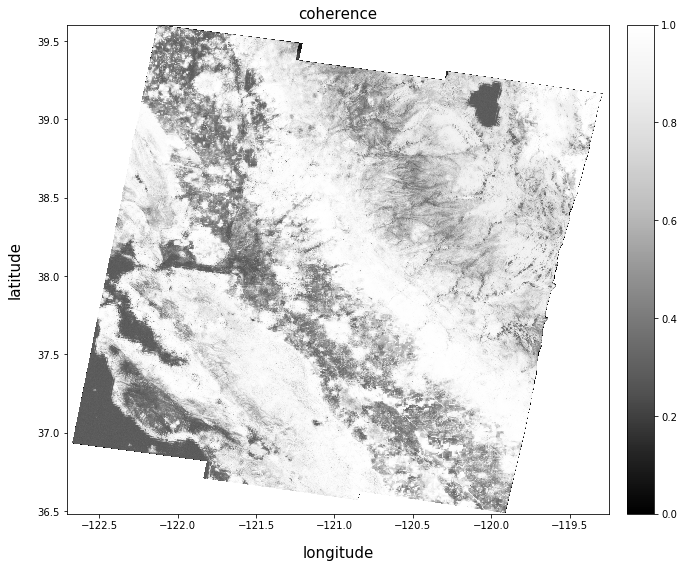

In [15]:
plot_layer('figures/avgcoherence.vrt','coherence')

To calculate the average coherence raster individually:
```
!ariaPlot.py -f "products/*.nc"  -makeavgoh
```

## Spatial coverage plots

Users can analyze the spatial extend of interferograms over their study area using the **` --plottracks`** option in **`ariaPlot.py`**. The spatial bounding box information is loaded on the fly from GUNW products.

In [16]:
!ariaPlot.py -f 'products/*.nc' -plottracks

***Plotting Function:***
All (48) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (24) interferograms are spatially continuous.
- Make plot of track latitude extents vs bounding bbox/common track extent.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


###  1. Latitude extent of interferograms (--plottracks)

Below we visualize the latitude extent as extracted above. Each vertical line shows the latitude extent of an interferogram, while the horizontal lines shows the common intersection area between all interferograms as well as the final bounding box that is used in the processing. By default, the bounding box is set to the common intersection of all interferograms. Users can specify the **`--bbox`** option as well as the **`--croptoptounion`** to change the final bounding box used in the processing.

<img src="figures/lat_extents.eps" alt="Latitude Extents" width="1000">
